In [11]:
from sklearn.neighbors import KNeighborsClassifier as kNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import numpy as np

# import dataset packages
from sklearn.datasets import make_blobs, make_checkerboard, make_circles, make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

# import from project files
from utils import plot_2d, plot_classifier_boundary, test_model
from plots import plot_test_training_err, plot_test_training_auc
from evaluation import dt_classifier_auc, dt_classifier_score, knn_classifier_err, knn_classifier_auc

## Dataset Generation ## 

### kNN ###
General: 
- Bla


Advantages:
- Easy to implement for multiclass problems


Disadvantages:
- KNN is very sensitive to outliers
- Dimensionality: KNN is more appropriate to use when you have a small number of inputs.
- Class imbalance can be an issue: kNN might wrongly vote for majority class
- Sample size needs to be large enough and dense enough


### Decision Trees ###
General: 
- The key idea is to use a decision tree to partition the data space into dense regions and sparse regions.


Advantages:
- Good with High Level Data: e.g. age, income
- Cases of missing values and outliers have less significance on the decision tree’s data.


Disadvantages:
- Bad with Low Level Data: data with many predictors/inputs
- Trees can overfit: Overfitting increases with depth of tree

In [12]:
def data_nn():

    nn_X, nn_y = make_blobs(
        n_samples=1500,
        n_features=2,
        centers=220,
        cluster_std=.16,
        random_state=42
    )
    nn_y = nn_y % 2 # to reduce the amount of different labels to 2

    return nn_X, nn_y

In [13]:
def data_dt():  
            
    X = []
    y = []
    for col, i in enumerate(np.arange(0, 10, 10/32, dtype=float)):
        for j in np.arange(0, 10, 10/32, dtype=float):
            X.append(np.array([i, j]))
            y.append(col % 2)
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X, y


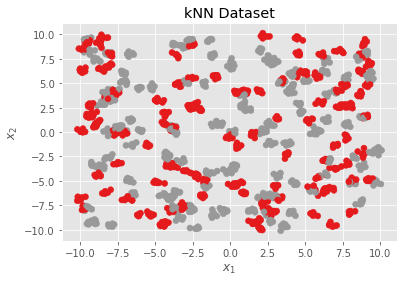

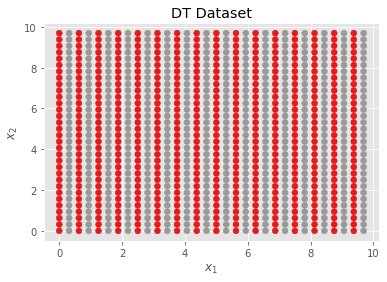

In [14]:
# kNN data generation and splitup
nn_X, nn_y = data_nn()
plot_2d(nn_X, nn_y, 'kNN Dataset')
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X, nn_y, test_size=.33, random_state=42)

# Decision Tree data generation and splitup
dt_X, dt_y = data_dt()
plot_2d(dt_X, dt_y, 'DT Dataset')
dt_X_train, dt_X_test, dt_y_train, dt_y_test = train_test_split(dt_X, dt_y, test_size=.33, random_state=42)


## Evaluation and Plotting Methods ##

In [15]:
#  Underfitting – Validation and training error high
#  Overfitting – Validation error is high, training error low
#  Good fit – Validation error low, slightly higher than the training error
#  Unknown fit - Validation error low, training error 'high'

## Hyperparameters ##

In [16]:
# Hyperparameters

# kNN
k_nn = 3
k_dt = 17
k_values = np.arange(1, 30, 2)

# Decision Trees
criterion = 'entropy'
# min_samples_split best between [2, 40] (see https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680)
# if value too small trees tend to overfit
# Imbalanced class problem: because then regions in which the minority class will be in majority 
# will be very small so min_samples_split should be lower
min_samples_split_nn = 6
min_samples_split_dt = 2
nsamples = np.arange(2, 60, 2)
max_depth_nn = 25
max_depth_dt = None
ndepth = np.arange(1, 60, 5)

## Dataset NN - Neareast Neighbors ##

#### kNN performing better than Decision Trees ####

Dataset NN consists of two classes, that each have multiple individual and randomly placed clusters. kNN is able to approximate them very well, because it can adapt to arbitrarily formed decision boundaries. Decision Trees also don't perform bad but due to their nature of splitting the data space into regions, which only split the dataset into horizontal and vertical lines, it is not able to approximate the dataset as well as kNN.

kNN Performance on Dataset NN:
AUC score: 0.925
AUC score list: [0.9454892741698502, 0.9212811806190415, 0.9211724948574787, 0.9355102040816325, 0.9189447383891828, 0.9369067103109656, 0.923265306122449, 0.9151702482582671, 0.9105973813420623, 0.9231993600626878]


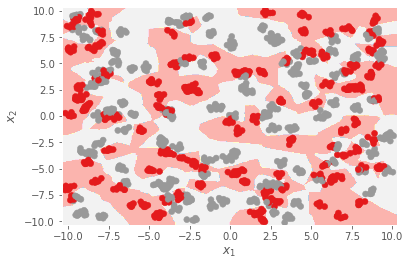

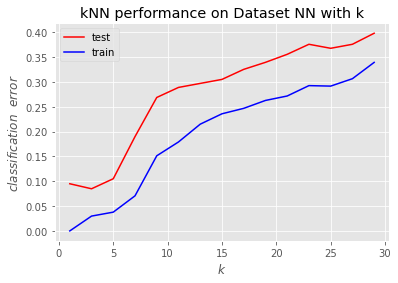

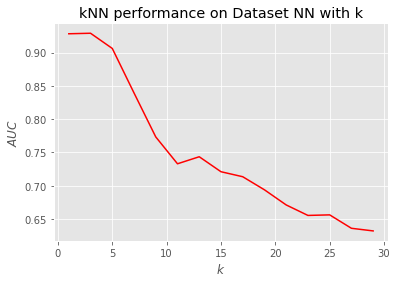

In [17]:
# kNN
print('kNN Performance on Dataset NN:')
knn = kNC(n_neighbors=k_nn)
test_model(knn, nn_X, nn_y)

# Hyperparameter Tuning
errors = map(lambda k: knn_classifier_err(k, nn_X_train, nn_y_train, nn_X_test, nn_y_test), k_values)
plot_test_training_err(k_values, errors, title='kNN performance on Dataset NN with k', hyperparam='k')

aucs = map(lambda k: knn_classifier_auc(k, nn_X, nn_y), k_values)
plot_test_training_auc(k_values, aucs, title='kNN performance on Dataset NN with k', hyperparam='k')



Decision Trees Performance on Dataset NN:
AUC score: 0.828
AUC score list: [0.7873567921440261, 0.8404838867665786, 0.8181996277794104, 0.8686067019400352, 0.8338699660041842, 0.7960209989206162, 0.8403369575864432, 0.8465684513115344, 0.8101185228719757, 0.8422986478542034]


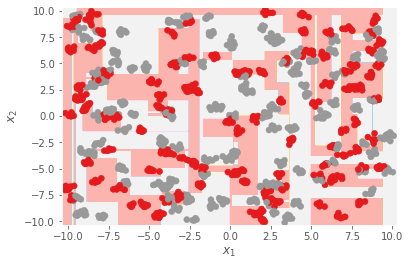

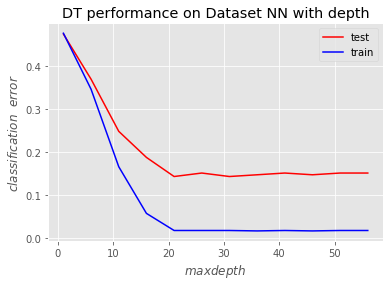

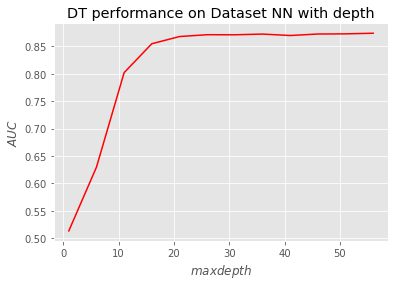

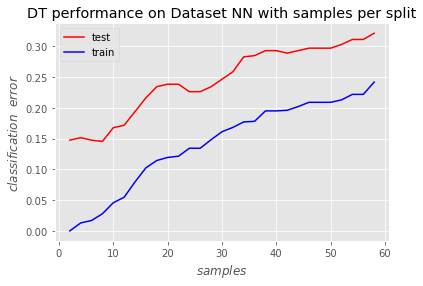

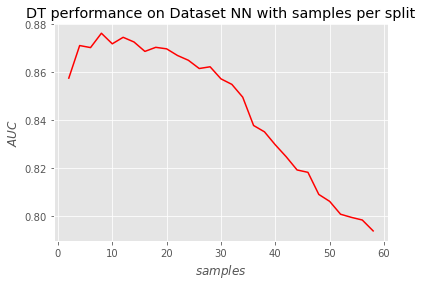

In [18]:
# Decision Trees

print('Decision Trees Performance on Dataset NN:')
dtree=DTC(criterion=criterion, max_depth=max_depth_nn, min_samples_split=min_samples_split_nn)
test_model(dtree, nn_X, nn_y)

# Hyperparam Tuning
errors = map(lambda depth: dt_classifier_score(
    nn_X_train, nn_y_train, 
    nn_X_test, nn_y_test, 
    max_depth=depth,
    min_samples_split=min_samples_split_nn), ndepth)
plot_test_training_err(ndepth, errors, title='DT performance on Dataset NN with depth', hyperparam='max depth')

aucs = map(lambda depth: dt_classifier_auc(nn_X, nn_y, max_depth=depth, min_samples_split=min_samples_split_nn), ndepth)
plot_test_training_auc(ndepth, aucs, title='DT performance on Dataset NN with depth', hyperparam='max depth')

errors = map(lambda sample: dt_classifier_score(
    nn_X_train, nn_y_train, 
    nn_X_test, nn_y_test, 
    max_depth=max_depth_nn, 
    min_samples_split=sample), nsamples)
plot_test_training_err(nsamples, errors, title='DT performance on Dataset NN with samples per split', hyperparam='samples')

aucs = map(lambda sample: dt_classifier_auc(nn_X, nn_y, max_depth=max_depth_nn, min_samples_split=sample), nsamples)
plot_test_training_auc(nsamples, aucs, title='DT performance on Dataset NN with samples per split', hyperparam='samples')


## Dataset DT - Decision Trees ##

#### Decision Trees performing better than kNN ####

Dataset DT consists of two classes, that are distributed in vertical lines/columns alternating between the classes. All datapoints have the same distance to oneanother. Decision Trees can optimally approximate this dataset while kNN almost randomly assigns classes. Each data point has almost the same amount of neighbors from class 1 and class 2. 

kNN Performance on Dataset DT:
AUC score: 0.691
AUC score list: [0.7544378698224852, 0.6654193457714065, 0.6995786516853932, 0.7065811606391925, 0.7487384356602187, 0.6753547031003678, 0.6998773865825889, 0.640262113067004, 0.6390445502942, 0.6775147928994083]


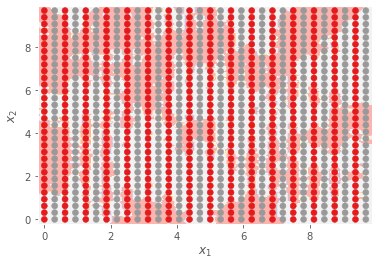

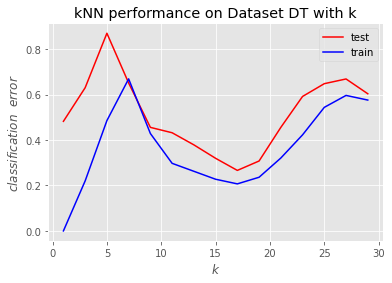

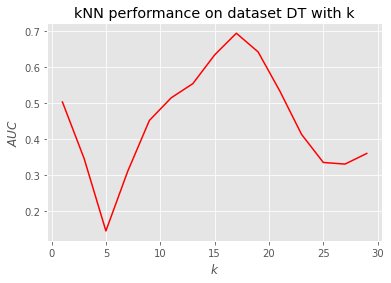

In [19]:
# kNN
print('kNN Performance on Dataset DT:')
knn = kNC(n_neighbors=k_dt)
test_model(knn, dt_X, dt_y)

# Hyperparameter Tuning
errors = map(lambda k: knn_classifier_err(k, dt_X_train, dt_y_train, dt_X_test, dt_y_test), k_values)
plot_test_training_err(k_values, errors, title='kNN performance on Dataset DT with k', hyperparam='k')

aucs = map(lambda k: knn_classifier_auc(k, dt_X, dt_y), k_values)
plot_test_training_auc(k_values, aucs, title='kNN performance on dataset DT with k', hyperparam='k')


Decision Trees Performance on Dataset B:
AUC score: 1.000
AUC score list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


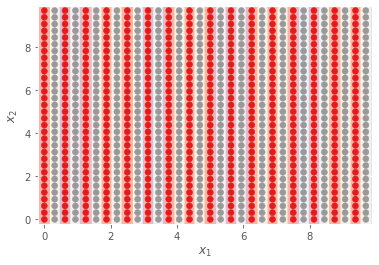

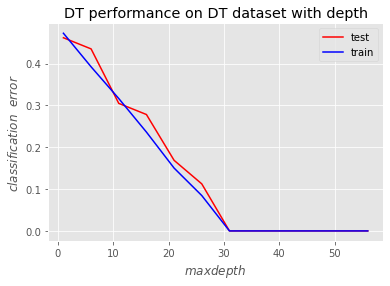

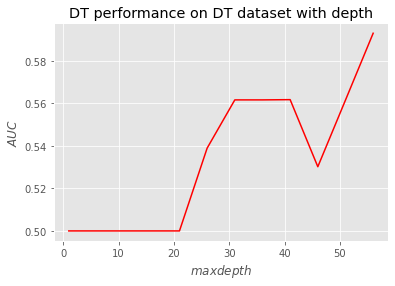

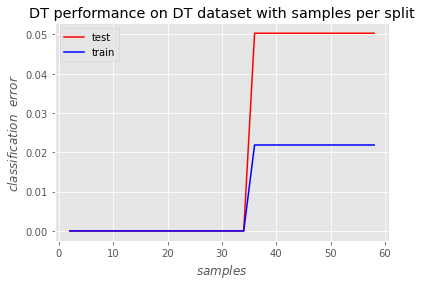

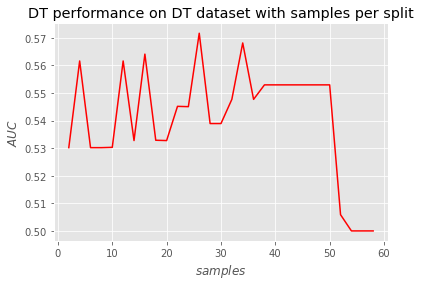

In [20]:
# Decision Trees

print('Decision Trees Performance on Dataset B:')
dtree=DTC(criterion='entropy', max_depth=max_depth_dt, min_samples_split=min_samples_split_dt)
test_model(dtree, dt_X, dt_y)

# Hyperparameter Tuning
# max depth
errors = map(lambda depth: dt_classifier_score(
    dt_X_train, dt_y_train, 
    dt_X_test, dt_y_test, 
    max_depth=depth,
    min_samples_split=min_samples_split_dt), ndepth)

plot_test_training_err(ndepth, errors, title='DT performance on DT dataset with depth', hyperparam='max depth')

aucs = map(lambda depth: dt_classifier_auc(dt_X, dt_y, max_depth=depth, min_samples_split=min_samples_split_dt), ndepth)
plot_test_training_auc(ndepth, aucs, title='DT performance on DT dataset with depth', hyperparam='max depth')

# min samples per split
errors = map(lambda sample: dt_classifier_score(
    dt_X_train, dt_y_train, 
    dt_X_test, dt_y_test,
    max_depth=max_depth_dt,
    min_samples_split=sample), nsamples)

plot_test_training_err(nsamples, errors, title='DT performance on DT dataset with samples per split', hyperparam='samples')

aucs = map(lambda sample: dt_classifier_auc(dt_X, dt_y, max_depth=max_depth_dt, min_samples_split=sample), nsamples)
plot_test_training_auc(nsamples, aucs, title='DT performance on DT dataset with samples per split', hyperparam='samples')
